#Import files from Kaggle

In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pasithankijpongpan","key":"631ed83c5fccf415acc86f241c559c78"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [1]:
!kaggle datasets download -d prasunroy/natural-images
# !kaggle datasets download -d varump66/face-images-13233

 97% 333M/342M [00:03<00:00, 85.7MB/s]
100% 342M/342M [00:03<00:00, 97.7MB/s]


In [2]:
import zipfile
zip_ref = zipfile.ZipFile('natural-images.zip', 'r')
# zip_ref = zipfile.ZipFile('face-images-13233.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [5]:
# Import lib
from keras import models
from keras.layers import Conv2D, InputLayer, UpSampling2D
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split

#RGB color space

##**1. Load files to workspace**

###Util functions

In [3]:
# Function for load data
def load_data(dir: str, color_mode: str, imgsize: tuple, sample = -1):
  sample = len(os.listdir(dir)) if sample == -1 else sample
  data_path = [os.path.join(dir, filename) for i, filename in enumerate(os.listdir(dir)) if i < sample ]
  img_list = [load_img(path, color_mode=color_mode, target_size= imgsize) for path in data_path]
  img_arr = np.array([img_to_array(img) for img in img_list])
  return img_arr

In [4]:
def create_inception_feature(data):
  data = np.stack([data, data, data], axis=3) 
  data = np.squeeze(data)
  return data

###1.1 Load data

In [5]:
# RGB COLOR SPACE

# specify where to load data and how to label it
IMG_PATH = '/content/files/natural_images/person'

feature = load_data(IMG_PATH, 'grayscale', (128,128))
label = load_data(IMG_PATH, 'rgb', (128,128))

feature = feature/255
label = label/255

# train test split
feature_train, feature_test, label_train, label_test = train_test_split(feature, label, test_size=0.15, random_state=555)

print("feature train shape:", feature_train.shape)
print("feature test shape:", feature_test.shape)

# Prepare data for InceptionV2
feature_incep = load_data(IMG_PATH, 'grayscale', (299,299))
label_incep = load_data(IMG_PATH, 'rgb', (299,299))

feature_incep = feature_incep/255
label_incep = label_incep/255

feature_incep = create_inception_feature(feature_incep)

# train test split
feature_incep_train, feature_incep_test, label_incep_train, label_incep_test = train_test_split(feature_incep, label_incep, test_size=0.15, random_state=555)


print('incep train shape:', feature_incep_train.shape)
print('incep test shape:', feature_incep_test.shape)

feature train shape: (838, 128, 128, 1)
feature test shape: (148, 128, 128, 1)
incep train shape: (838, 299, 299, 3)
incep test shape: (148, 299, 299, 3)


###1.2 Visualize

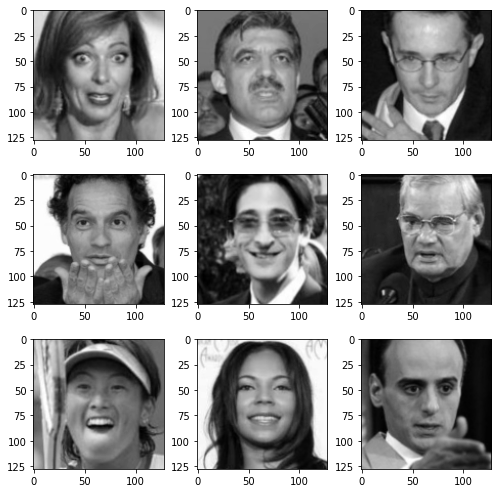

In [11]:
# show img labels
plt.figure(figsize=(7, 7))
for index, img in enumerate(feature_train[:9, :, :, 0]):
    plt.subplot(3, 3, index+1)
    plt.imshow(img, cmap='gray')
plt.tight_layout()
plt.show()

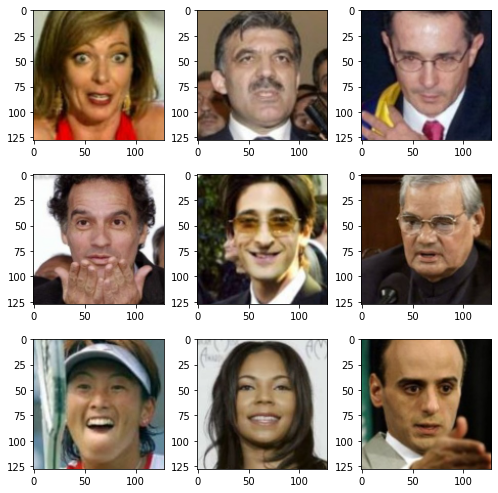

In [12]:
# show img labels
plt.figure(figsize=(7, 7))
for index, img in enumerate(label_train[:9, :, :, :]):
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
plt.tight_layout()
plt.show()

##**2. Build Model**

###Util functions

In [13]:
# define a function to plot the result from training step
def show_result(history): 
    
    # Print the result from the last epoch
    print('Last train mse: %s'%history.history['loss'][-1])
    
    loss = history.history['loss']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,1,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.set_title('Training loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('loss')
    loss_plot.legend()

###2.1 Define model

225214464/225209952 [==============================] - 1s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 128)  73856       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 256)  295168      conv2d_1[0][0]                   
____________________

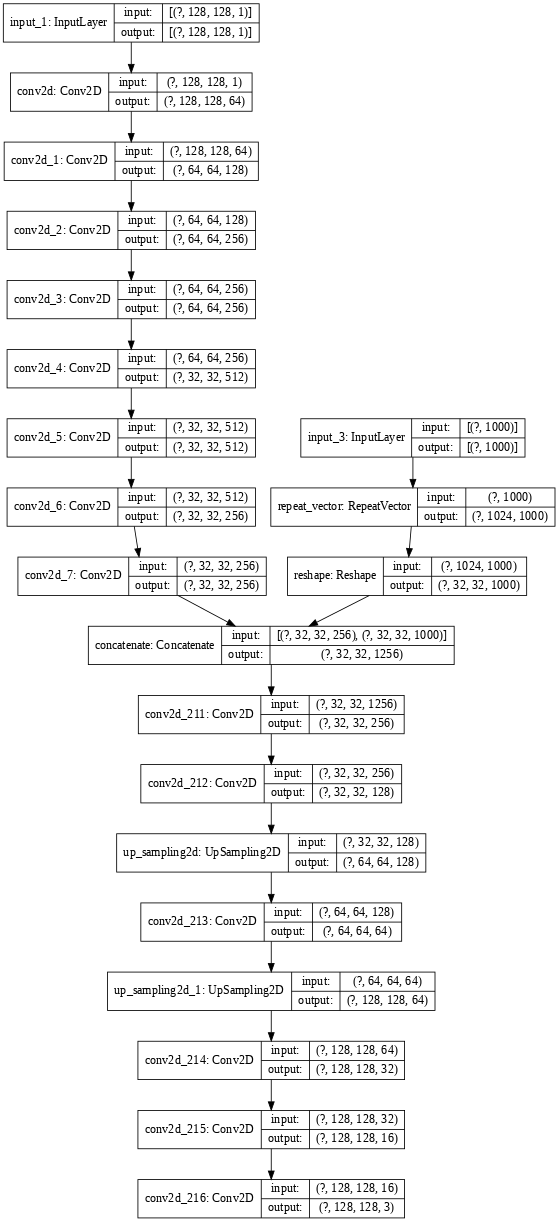

In [14]:
from keras.applications import inception_resnet_v2 as incepv2
from keras.layers import Input, Concatenate, RepeatVector, Reshape, Dropout
from keras import Model
from keras.utils.vis_utils import plot_model

# Encoder
encoder_input_shape = feature_train.shape[1:]
encoder_input = Input(shape= encoder_input_shape)
x = Conv2D(64, (3,3), activation='relu', padding='same')(encoder_input)
x = Conv2D(128, (3,3), activation='relu', padding='same', strides=(2,2))(x)
x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
# x = Dropout(0.5)(x)
x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = Conv2D(512, (3,3), activation='relu', padding='same', strides=(2,2))(x)
x = Conv2D(512, (3,3), activation='relu', padding='same')(x)
# x = Dropout(0.5)(x)
x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
encoded = Conv2D(256, (3,3), activation='relu', padding='same')(x)

# Feature extractor
feature_extractor = incepv2.InceptionResNetV2()

# Fusion
embed_input = Input(shape=(1000,))
x = RepeatVector(32 * 32)(embed_input) 
x = Reshape(([32, 32, 1000]))(x)
fusion_input = Concatenate(axis=3)([encoded, x])
fusion_output = Conv2D(256, (1,1), activation='relu', padding='same')(fusion_input)

# Decoder
# decoder_input = Input(shape= decoder_input_shape)
x = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
x = UpSampling2D(size=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D(size=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
deocoded = Conv2D(3, (3,3), activation='tanh', padding='same')(x)

# Build model
colorize_model = Model(inputs= [encoder_input, embed_input], outputs= deocoded)
colorize_model.summary()

plot_model(colorize_model, show_shapes=True, show_layer_names=True, dpi=60)


###2.2 Train model

Epoch 1/100
27/27 [==============================] - 9s 318ms/step - loss: 0.0984
Epoch 2/100
27/27 [==============================] - 8s 285ms/step - loss: 0.0204
Epoch 3/100
27/27 [==============================] - 8s 288ms/step - loss: 0.0114
Epoch 4/100
27/27 [==============================] - 8s 291ms/step - loss: 0.0086
Epoch 5/100
27/27 [==============================] - 8s 293ms/step - loss: 0.0075
Epoch 6/100
27/27 [==============================] - 8s 296ms/step - loss: 0.0068
Epoch 7/100
27/27 [==============================] - 8s 300ms/step - loss: 0.0060
Epoch 8/100
27/27 [==============================] - 8s 302ms/step - loss: 0.0062
Epoch 9/100
27/27 [==============================] - 8s 304ms/step - loss: 0.0056
Epoch 10/100
27/27 [==============================] - 8s 306ms/step - loss: 0.0065
Epoch 11/100
27/27 [==============================] - 8s 305ms/step - loss: 0.0055
Epoch 12/100
27/27 [==============================] - 8s 302ms/step - loss: 0.0054
Epoch 13/100


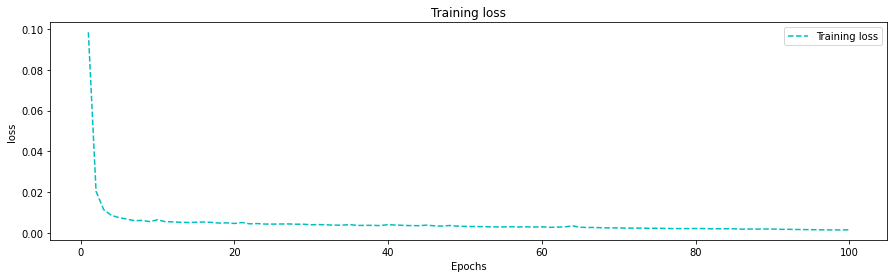

In [19]:
# Extract feature from InceptionV2
extracted_feature = feature_extractor.predict(feature_incep_train)

# Compile model
colorize_model.compile(optimizer='adam', loss='mse')

# Train model
EPOCH = 100
BATCH_SIZE = 32

hist = colorize_model.fit([feature_train, extracted_feature], label_train, epochs= EPOCH, batch_size= BATCH_SIZE)
show_result(hist)

In [20]:
colorize_model.save('colorize_model_RGB_V1.h5')

###2.3 Evaluate model

In [41]:
# Extract test images features
extracted_test_feature = feature_extractor(feature_incep_test)

# Evaluate model
colorize_model.evaluate([feature_test, extracted_test_feature], label_test)

5/5 [==============================] - 0s 74ms/step - loss: 0.0060


0.005964131560176611

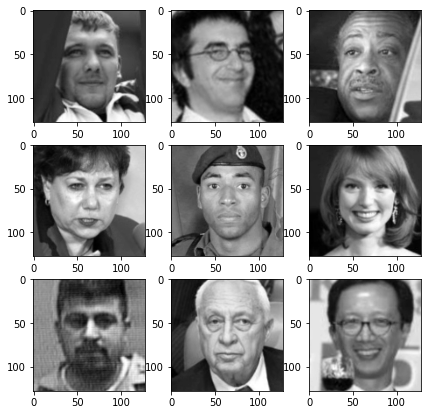

In [47]:
# Input examples
plt.figure(figsize=(7,7))
for i, img in enumerate(feature_test[:9]):
  plt.subplot(3,3,i+1)
  plt.imshow(feature_test[i,:,:,0], cmap='gray')
plt.show()

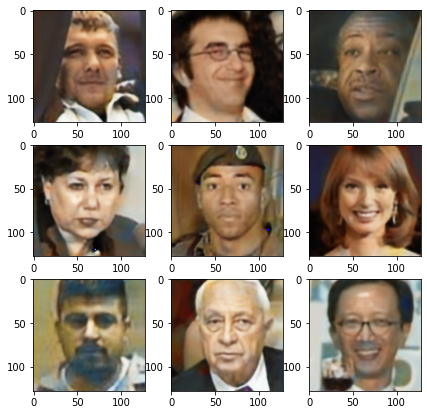

In [45]:
# Predicted examples
plt.figure(figsize=(7,7))
pred = colorize_model.predict([feature_test, extracted_test_feature])
pred = pred * 255
for i, img in enumerate(pred[:9]):
  plt.subplot(3,3,i+1)
  plt.imshow(pred[i].astype('uint8'))
plt.show()

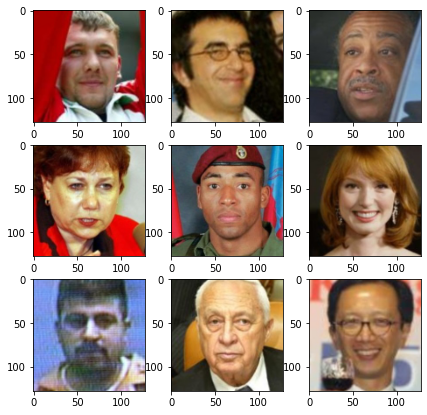

In [46]:
# Label examples
plt.figure(figsize=(7,7))
label_test = label_test * 255
for i, img in enumerate(label_test[:9]):
  plt.subplot(3,3,i+1)
  plt.imshow(label_test[i].astype('uint8'))
plt.show()

#LAB color space

##**1. Load files to workspace**

###Util functions

In [6]:
# Function for load data
def load_data(dir: str, color_mode: str, imgsize: tuple, sample = -1):
  sample = len(os.listdir(dir)) if sample == -1 else sample
  data_path = [os.path.join(dir, filename) for i, filename in enumerate(os.listdir(dir)) if i < sample ]
  img_list = [load_img(path, color_mode=color_mode, target_size= imgsize) for path in data_path]
  img_arr = np.array([img_to_array(img) for img in img_list])
  return img_arr

In [7]:
def create_inception_feature(data):
  data = np.stack([data, data, data], axis=3) 
  data = np.squeeze(data)
  return data

In [8]:
def extract_single_dim_from_LAB_convert_to_RGB(image,idim):
    z = np.zeros(image.shape)
    if idim != 0 :
        z[:,:,0]=80 ## I need brightness to plot the image along 1st or 2nd axis
    z[:,:,idim] = image[:,:,idim]
    z = color.lab2rgb(z)
    return(z)

###1.1 Load data

In [9]:
from skimage import color
# LAB COLOR SPACE

IMG_PATH = '/content/files/natural_images/person'

# Load image
img = load_data(IMG_PATH, 'rgb', (128,128))
img_incep = load_data(IMG_PATH, 'rgb', (299,299))

lab_img = img/255
lab_img_incep = img_incep/255

del img
del img_incep

# Convert RGB to Lab
lab_img = color.rgb2lab(lab_img)
lab_img_incep = color.rgb2lab(lab_img_incep)

# Specify feature and label
feature = lab_img[:,:,:,:1]
label = lab_img[:,:,:,1:]
label = label/128

feature_incep = lab_img_incep[:,:,:,:1]
label_incep = lab_img_incep[:,:,:,1:]
label_incep = label_incep/128

feature_incep = create_inception_feature(feature_incep)

# train test split
feature_train, feature_test, label_train, label_test = train_test_split(feature, label, test_size=0.15, random_state=555)

# train test split
feature_incep_train, feature_incep_test, label_incep_train, label_incep_test = train_test_split(feature_incep, label_incep, test_size=0.15, random_state=555)

del feature
del label
del feature_incep
del label_incep

print("feature train shape:", feature_train.shape)
print("feature test shape:", feature_test.shape)
print('incep train shape:', feature_incep_train.shape)
print('incep test shape:', feature_incep_test.shape)


feature train shape: (838, 128, 128, 1)
feature test shape: (148, 128, 128, 1)
incep train shape: (838, 299, 299, 3)
incep test shape: (148, 299, 299, 3)


###1.2 Visualize

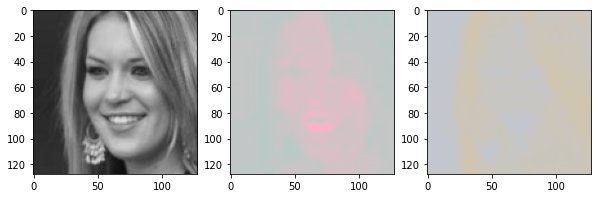

In [10]:
plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow( extract_single_dim_from_LAB_convert_to_RGB(lab_img[0],0) )
plt.subplot(1,3,2)
plt.imshow(extract_single_dim_from_LAB_convert_to_RGB(lab_img[0],1) )
plt.subplot(1,3,3)
plt.imshow(extract_single_dim_from_LAB_convert_to_RGB(lab_img[0],2) )
plt.show()

##**2. Build Model**

###Util functions

In [11]:
# define a function to plot the result from training step
def show_result(history): 
    
    # Print the result from the last epoch
    print('Last train mse: %s'%history.history['loss'][-1])
    
    loss = history.history['loss']
    
    epochs = range(1, len(loss) + 1)   
    
    # Define a subplot 
    fig, axs = plt.subplots(1,1,figsize=(15,4))
    
    # Plot loss
    loss_plot = axs
    
    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.set_title('Training loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('loss')
    loss_plot.legend()

###2.1 Define model

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 128)  73856       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 256)  295168      conv2d_1[0][0]                   
_______________________________________________________________________________________

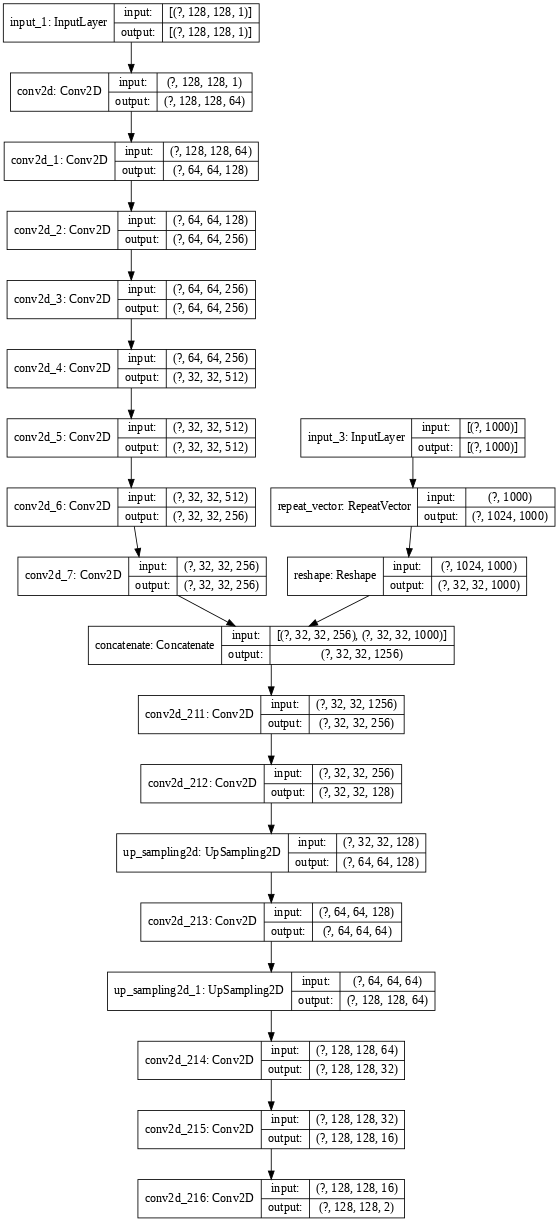

In [12]:
from keras.applications import inception_resnet_v2 as incepv2
from keras.layers import Input, Concatenate, RepeatVector, Reshape, Dropout
from keras import Model
from keras.utils.vis_utils import plot_model

# Encoder
encoder_input_shape = feature_train.shape[1:]
encoder_input = Input(shape= encoder_input_shape)
x = Conv2D(64, (3,3), activation='relu', padding='same')(encoder_input)
x = Conv2D(128, (3,3), activation='relu', padding='same', strides=(2,2))(x)
x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
# x = Dropout(0.5)(x)
x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
x = Conv2D(512, (3,3), activation='relu', padding='same', strides=(2,2))(x)
x = Conv2D(512, (3,3), activation='relu', padding='same')(x)
# x = Dropout(0.5)(x)
x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
encoded = Conv2D(256, (3,3), activation='relu', padding='same')(x)

# Feature extractor
feature_extractor = incepv2.InceptionResNetV2()

# Fusion
embed_input = Input(shape=(1000,))
x = RepeatVector(32 * 32)(embed_input) 
x = Reshape(([32, 32, 1000]))(x)
fusion_input = Concatenate(axis=3)([encoded, x])
fusion_output = Conv2D(256, (1,1), activation='relu', padding='same')(fusion_input)

# Decoder
# decoder_input = Input(shape= decoder_input_shape)
x = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
x = UpSampling2D(size=(2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D(size=(2,2))(x)
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
deocoded = Conv2D(2, (3,3), activation='tanh', padding='same')(x)

# Build model
colorize_model = Model(inputs= [encoder_input, embed_input], outputs= deocoded)
colorize_model.summary()

plot_model(colorize_model, show_shapes=True, show_layer_names=True, dpi=60)


###2.2 Train model

Epoch 1/100
27/27 [==============================] - 9s 324ms/step - loss: 0.0576
Epoch 2/100
27/27 [==============================] - 8s 287ms/step - loss: 0.0099
Epoch 3/100
27/27 [==============================] - 8s 290ms/step - loss: 0.0087
Epoch 4/100
27/27 [==============================] - 8s 292ms/step - loss: 0.0082
Epoch 5/100
27/27 [==============================] - 8s 296ms/step - loss: 0.0082
Epoch 6/100
27/27 [==============================] - 8s 299ms/step - loss: 0.0080
Epoch 7/100
27/27 [==============================] - 8s 299ms/step - loss: 0.0078
Epoch 8/100
27/27 [==============================] - 8s 296ms/step - loss: 0.0077
Epoch 9/100
27/27 [==============================] - 8s 294ms/step - loss: 0.0076
Epoch 10/100
27/27 [==============================] - 8s 293ms/step - loss: 0.0075
Epoch 11/100
27/27 [==============================] - 8s 292ms/step - loss: 0.0074
Epoch 12/100
27/27 [==============================] - 8s 294ms/step - loss: 0.0073
Epoch 13/100


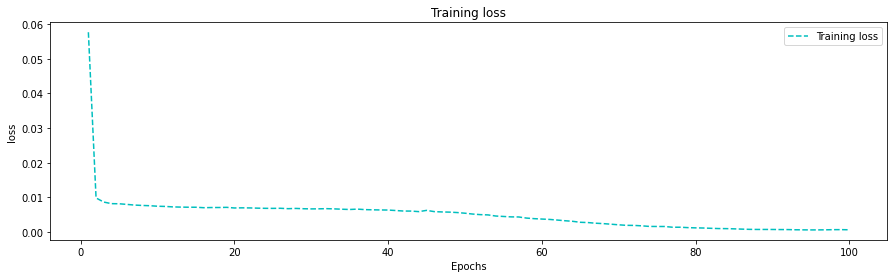

In [13]:
# Extract feature from InceptionV2
extracted_feature = feature_extractor.predict(feature_incep_train)

# Compile model
colorize_model.compile(optimizer='adam', loss='mse')

# Train model
EPOCH = 100
BATCH_SIZE = 32

hist = colorize_model.fit([feature_train, extracted_feature], label_train, epochs= EPOCH, batch_size= BATCH_SIZE)
show_result(hist)

In [19]:
colorize_model.save('colorize_model_LAB_V1.h5')

###2.3 Evaluate model

In [14]:
# Extract test images features
extracted_test_feature = feature_extractor(feature_incep_test)

# Evaluate model
colorize_model.evaluate([feature_test, extracted_test_feature], label_test)

5/5 [==============================] - 1s 260ms/step - loss: 0.0082


0.008225115947425365

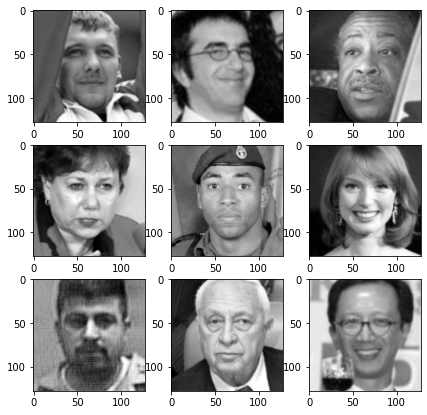

In [15]:
# Input examples
plt.figure(figsize=(7,7))
for i, img in enumerate(feature_test[:9]):
  plt.subplot(3,3,i+1)
  plt.imshow(feature_test[i,:,:,0], cmap='gray')
plt.show()

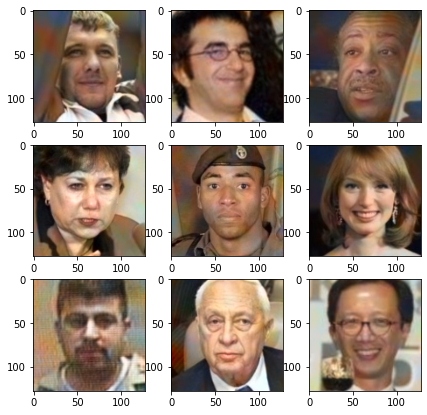

In [16]:
# Predicted examples
plt.figure(figsize=(7,7))
pred = colorize_model.predict([feature_test, extracted_test_feature])
pred = pred * 128
canvas = np.zeros((148, 128, 128, 3))
canvas[:, :, :, 0] = feature_test[:,:,:,0]
canvas[:, :, :, 1:] = pred
canvas = [color.lab2rgb(img) for img in canvas]
for i, img in enumerate(canvas[:9]):
  plt.subplot(3,3,i+1)
  plt.imshow(canvas[i])
plt.show()

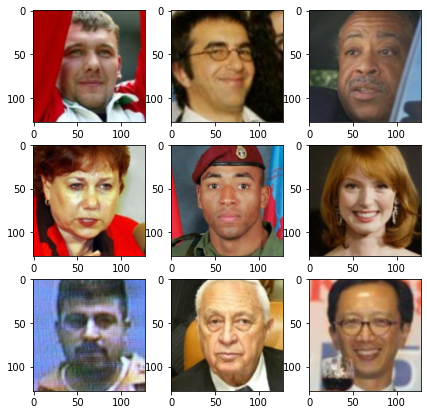

In [17]:
# Label examples
plt.figure(figsize=(7,7))
label_example = label_test * 128
canvas = np.zeros((148, 128, 128, 3))
canvas[:, :, :, 0] = feature_test[:,:,:,0]
canvas[:, :, :, 1:] = label_example
canvas = [color.lab2rgb(img) for img in canvas]
for i, img in enumerate(canvas[:9]):
  plt.subplot(3,3,i+1)
  plt.imshow(canvas[i])
plt.show()